# Diabetes Prediction Model

This notebook contains a comprehensive analysis and prediction model for diabetes using a large dataset with 100,000 records.

## 1. Introduction

Diabetes is a chronic disease that affects how your body turns food into energy. It occurs when your blood glucose (blood sugar) is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy.

Early detection of diabetes is crucial for effective management and prevention of complications. In this project, we will build a machine learning model to predict whether a person has diabetes based on various health metrics.

## 2. Import Libraries

First, let's import all the necessary libraries for our analysis.

In [10]:
# Import basic libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import os

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Import libraries for machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Load and Explore the Dataset

Let's load the dataset and take a look at its structure.

In [11]:
# Load the dataset
kaggle_input_path = '/kaggle/input/'

dataset_folder = 'diabetes-prediction-dataset'
file_name = 'diabetes_prediction_dataset.csv'

# Construct the full path to the CSV file
file_path = os.path.join(kaggle_input_path, dataset_folder, file_name)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [12]:
# Check the shape of the dataset
print(f"Dataset shape: {df.shape}")

Dataset shape: (100000, 9)


In [13]:
# Get information about the dataset
print("Dataset information:")
df.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [14]:
# Get statistical summary of the dataset
print("Statistical summary of numerical features:")
df.describe()

Statistical summary of numerical features:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [15]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Distribution of diabetes (target variable):
diabetes
0    91500
1     8500
Name: count, dtype: int64
Percentage of diabetic patients: 8.50%


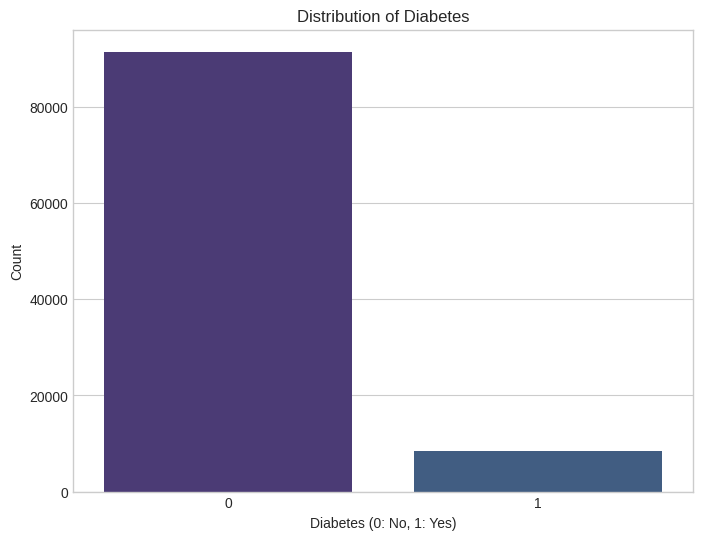

In [16]:
# Check the distribution of the target variable
print("Distribution of diabetes (target variable):")
print(df['diabetes'].value_counts())
print(f"Percentage of diabetic patients: {df['diabetes'].mean() * 100:.2f}%")

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')
plt.savefig('/kaggle/working/diabetes_distribution.png')
plt.show()

## 4. Data Cleaning and Preprocessing

Let's clean the data and prepare it for analysis.

In [17]:
# Check unique values in categorical columns
print("Unique values in 'gender':")
print(df['gender'].unique())

print("\nUnique values in 'smoking_history':")
print(df['smoking_history'].unique())

Unique values in 'gender':
['Female' 'Male' 'Other']

Unique values in 'smoking_history':
['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [18]:
# Handle any missing values if they exist
# For numerical columns, fill with median
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with mode
categorical_cols = ['gender', 'smoking_history']
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [19]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# Display the first few rows of the encoded dataset
print("First 5 rows of the encoded dataset:")
df_encoded.head()

First 5 rows of the encoded dataset:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False


## 5. Exploratory Data Analysis (EDA)

Let's explore the relationships between different features and the target variable.

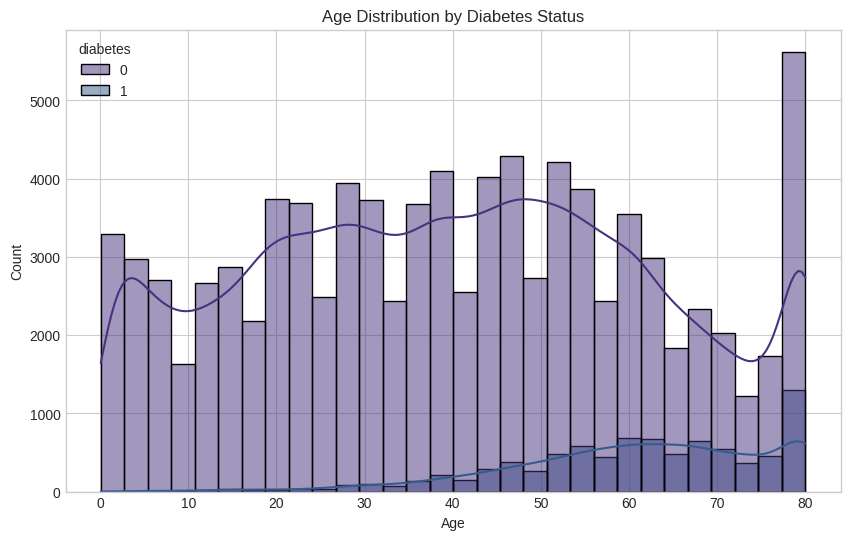

In [20]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='diabetes', kde=True, bins=30)
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('/kaggle/working/age_distribution.png')
plt.show()

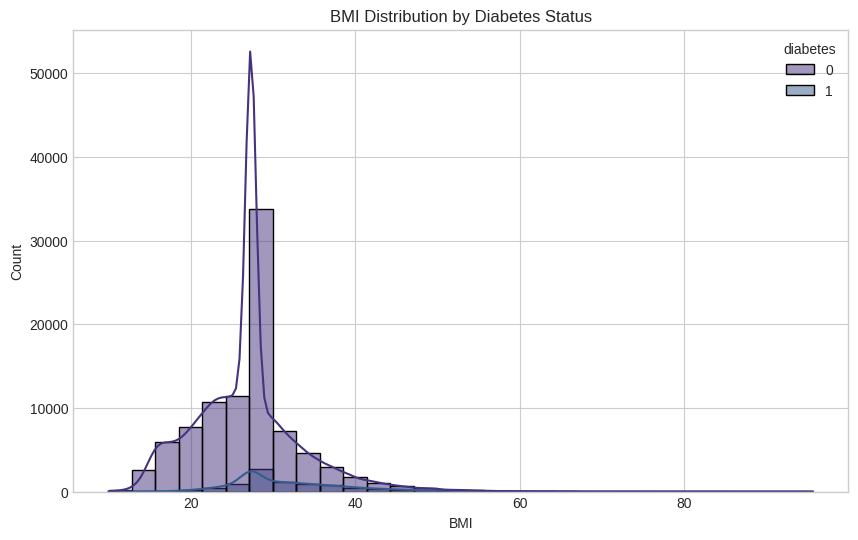

In [21]:
# Distribution of BMI
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='bmi', hue='diabetes', kde=True, bins=30)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.savefig('/kaggle/working/bmi_distribution.png')
plt.show()

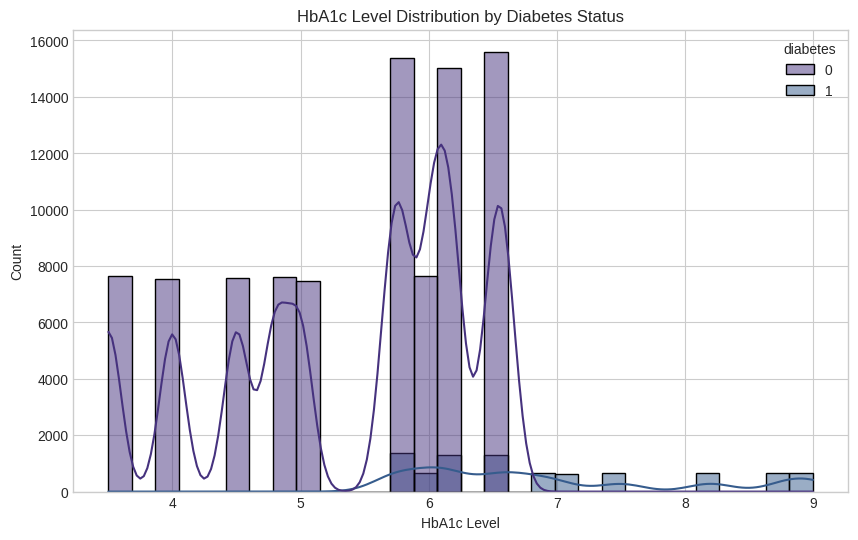

In [22]:
# Distribution of HbA1c level
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='HbA1c_level', hue='diabetes', kde=True, bins=30)
plt.title('HbA1c Level Distribution by Diabetes Status')
plt.xlabel('HbA1c Level')
plt.ylabel('Count')
plt.savefig('/kaggle/working/hba1c_distribution.png')
plt.show()

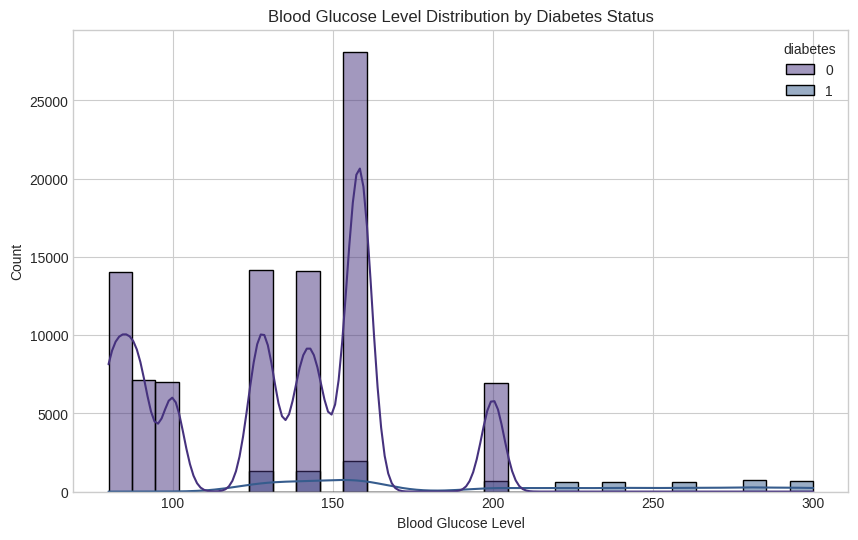

In [23]:
# Distribution of blood glucose level
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='blood_glucose_level', hue='diabetes', kde=True, bins=30)
plt.title('Blood Glucose Level Distribution by Diabetes Status')
plt.xlabel('Blood Glucose Level')
plt.ylabel('Count')
plt.savefig('/kaggle/working/glucose_distribution.png')
plt.show()

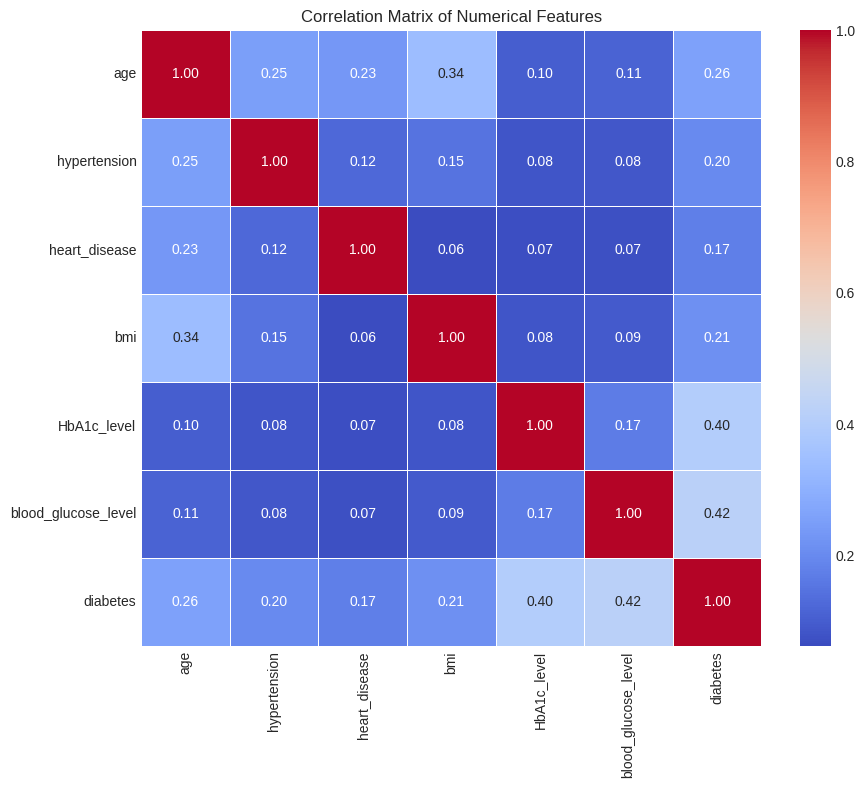

In [24]:
# Correlation matrix
# Select only numerical columns for correlation
numerical_df = df[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]

# Calculate correlation matrix
corr_matrix = numerical_df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('/kaggle/working/correlation_matrix.png')
plt.show()

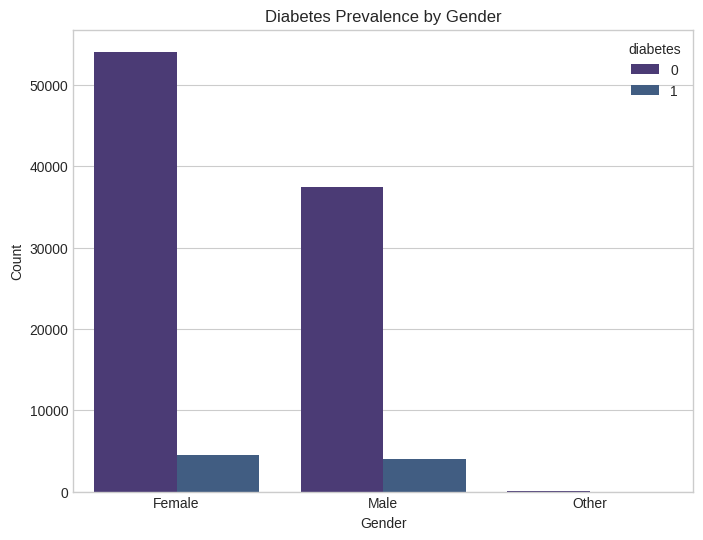

In [25]:
# Diabetes prevalence by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('Diabetes Prevalence by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('/kaggle/working/diabetes_by_gender.png')
plt.show()

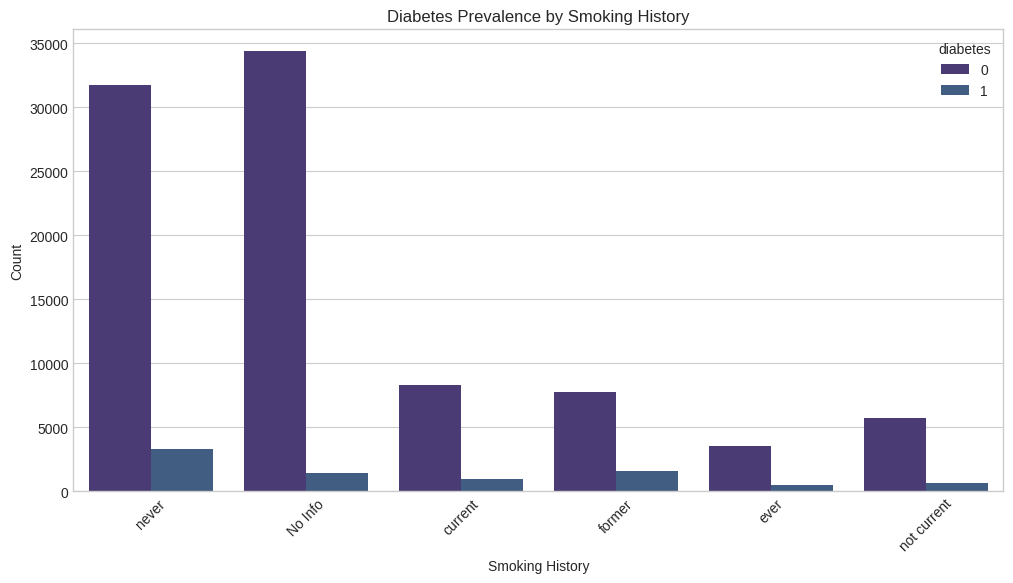

In [26]:
# Diabetes prevalence by smoking history
plt.figure(figsize=(12, 6))
sns.countplot(x='smoking_history', hue='diabetes', data=df)
plt.title('Diabetes Prevalence by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/diabetes_by_smoking.png')
plt.show()

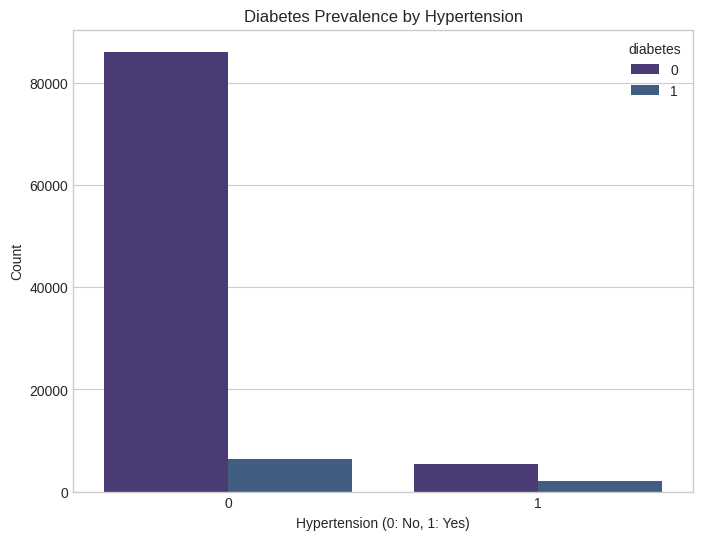

In [27]:
# Diabetes prevalence by hypertension
plt.figure(figsize=(8, 6))
sns.countplot(x='hypertension', hue='diabetes', data=df)
plt.title('Diabetes Prevalence by Hypertension')
plt.xlabel('Hypertension (0: No, 1: Yes)')
plt.ylabel('Count')
plt.savefig('/kaggle/working/diabetes_by_hypertension.png')
plt.show()

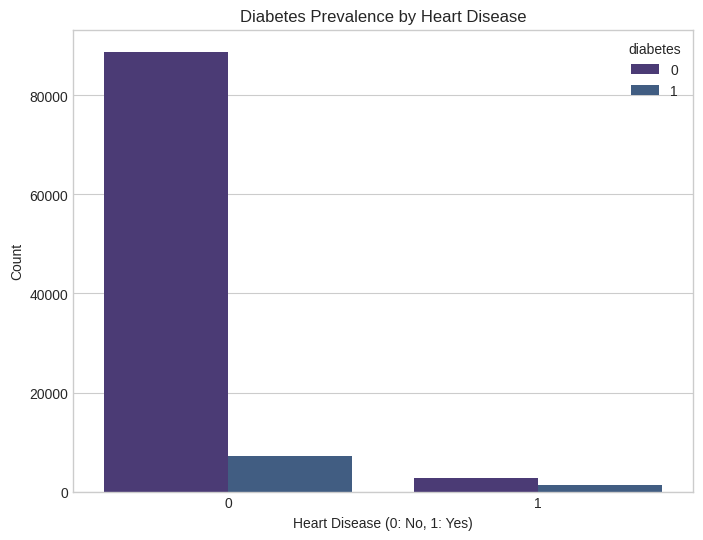

In [28]:
# Diabetes prevalence by heart disease
plt.figure(figsize=(8, 6))
sns.countplot(x='heart_disease', hue='diabetes', data=df)
plt.title('Diabetes Prevalence by Heart Disease')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.savefig('/kaggle/working/diabetes_by_heart_disease.png')
plt.show()

<Figure size 1500x1500 with 0 Axes>

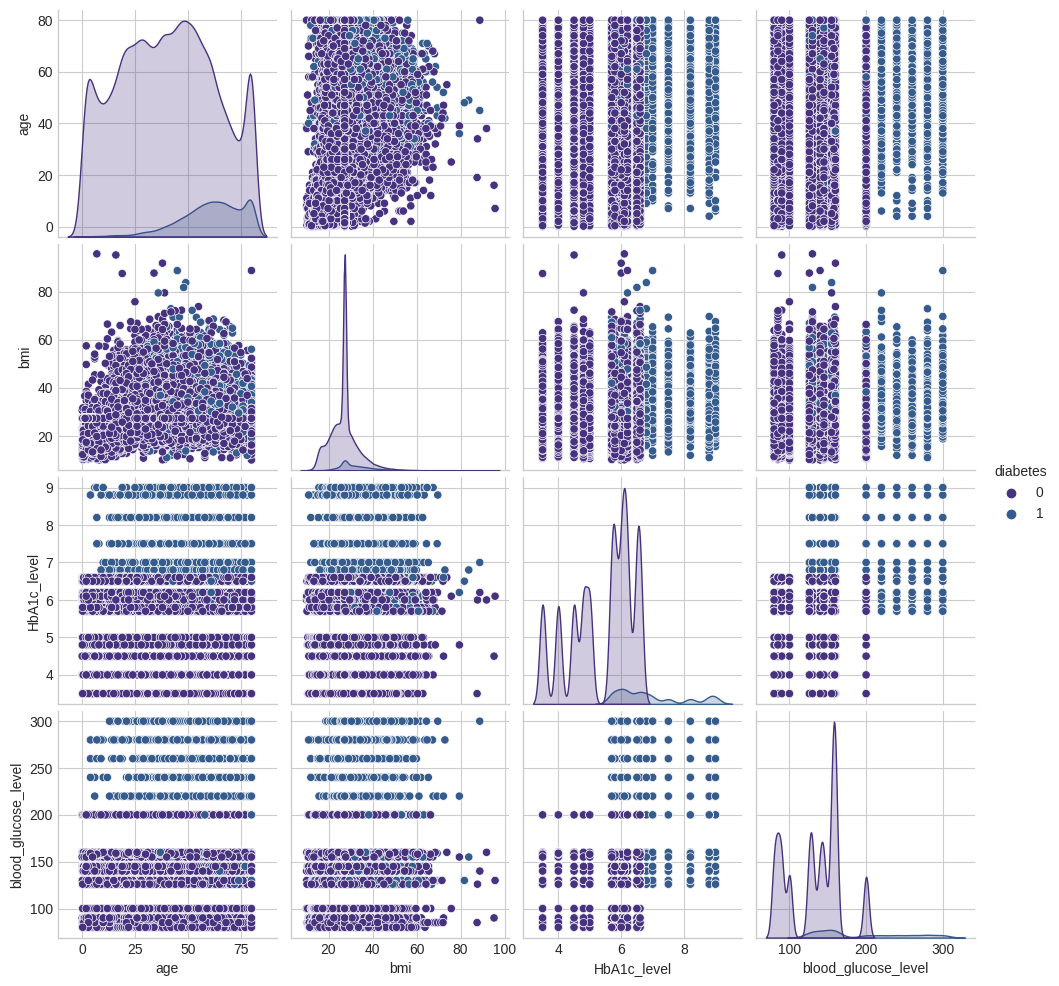

In [29]:
# Pairplot for numerical features
plt.figure(figsize=(15, 15))
sns.pairplot(data=df, vars=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes')
plt.savefig('/kaggle/working/pairplot.png')
plt.show()

## 6. Feature Selection and Data Preparation

Let's prepare our data for modeling.

In [30]:
# Separate features and target variable
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

# Display the features
print("Features used for modeling:")
print(X.columns.tolist())

Features used for modeling:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_Male', 'gender_Other', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']


In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (80000, 13)
Testing set shape: (20000, 13)


In [32]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7. Model Building and Evaluation

Let's build and evaluate different machine learning models.

### 7.1 Logistic Regression

Logistic Regression Model Evaluation:
Accuracy: 0.9590
Precision: 0.8639
Recall: 0.6171
F1 Score: 0.7199


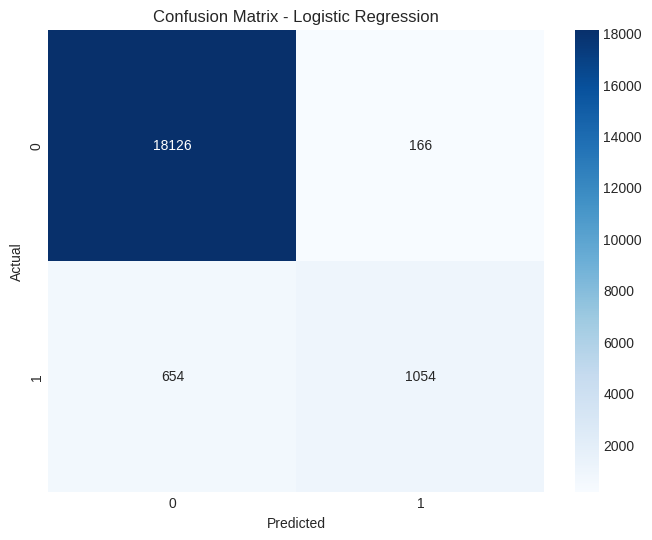


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18292
           1       0.86      0.62      0.72      1708

    accuracy                           0.96     20000
   macro avg       0.91      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000



In [33]:
# Build a logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/kaggle/working/lr_confusion_matrix.png')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

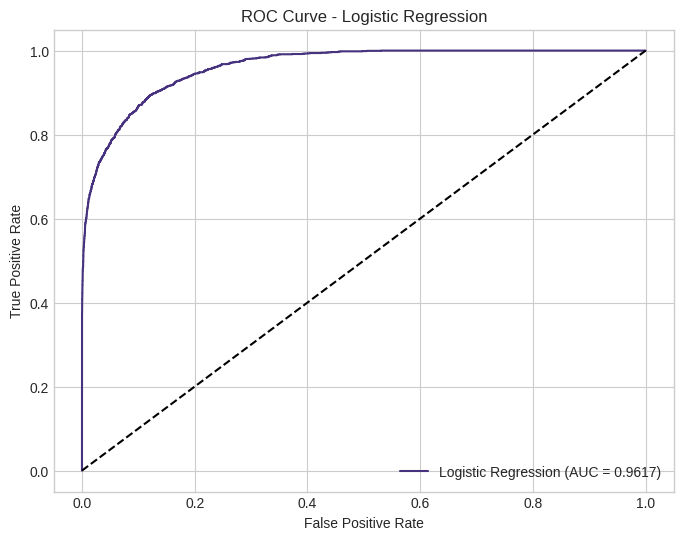

In [34]:
# ROC curve for logistic regression
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/lr_roc_curve.png')
plt.show()

### 7.2 Decision Tree

Decision Tree Model Evaluation:
Accuracy: 0.9519
Precision: 0.7097
Recall: 0.7400
F1 Score: 0.7246


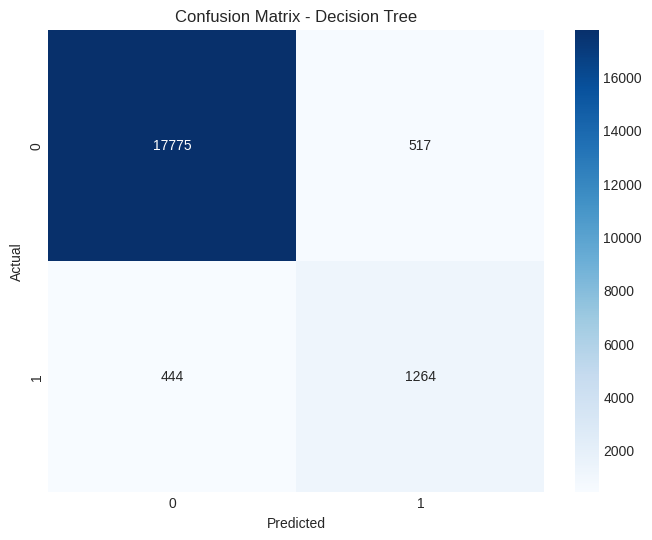


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18292
           1       0.71      0.74      0.72      1708

    accuracy                           0.95     20000
   macro avg       0.84      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



In [35]:
# Build a decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the model
print("Decision Tree Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/kaggle/working/dt_confusion_matrix.png')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

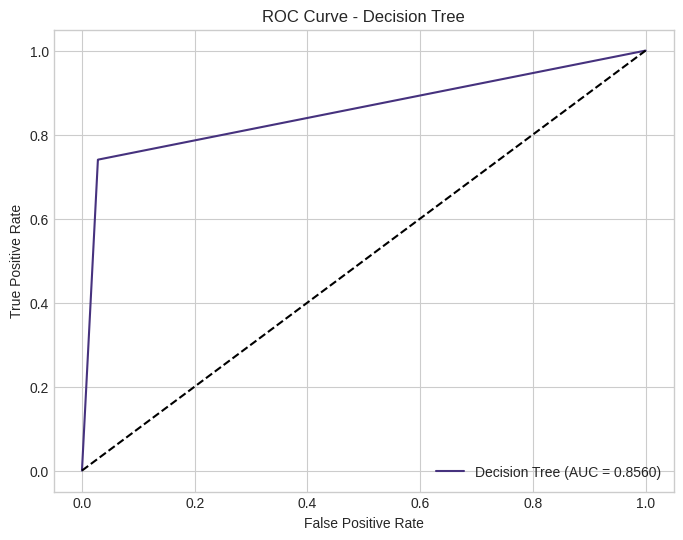

In [36]:
# ROC curve for decision tree
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/dt_roc_curve.png')
plt.show()

### 7.3 Random Forest

Random Forest Model Evaluation:
Accuracy: 0.9699
Precision: 0.9467
Recall: 0.6868
F1 Score: 0.7961


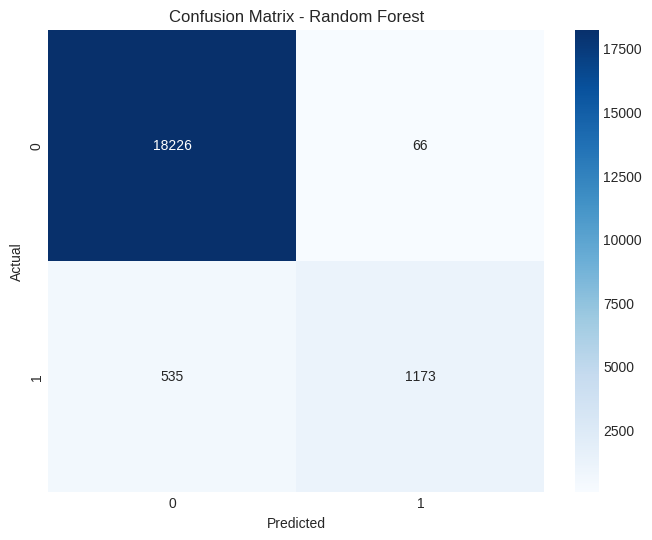


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.95      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



In [37]:
# Build a random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/kaggle/working/rf_confusion_matrix.png')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

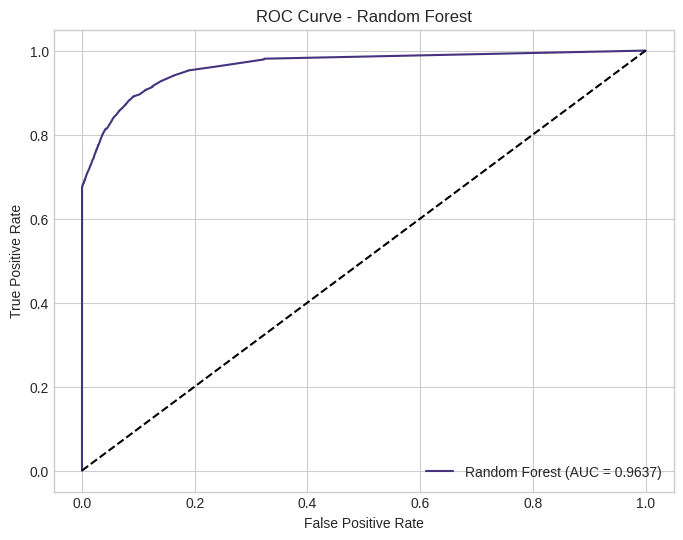

In [38]:
# ROC curve for random forest
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/rf_roc_curve.png')
plt.show()

### 7.4 Compare Models

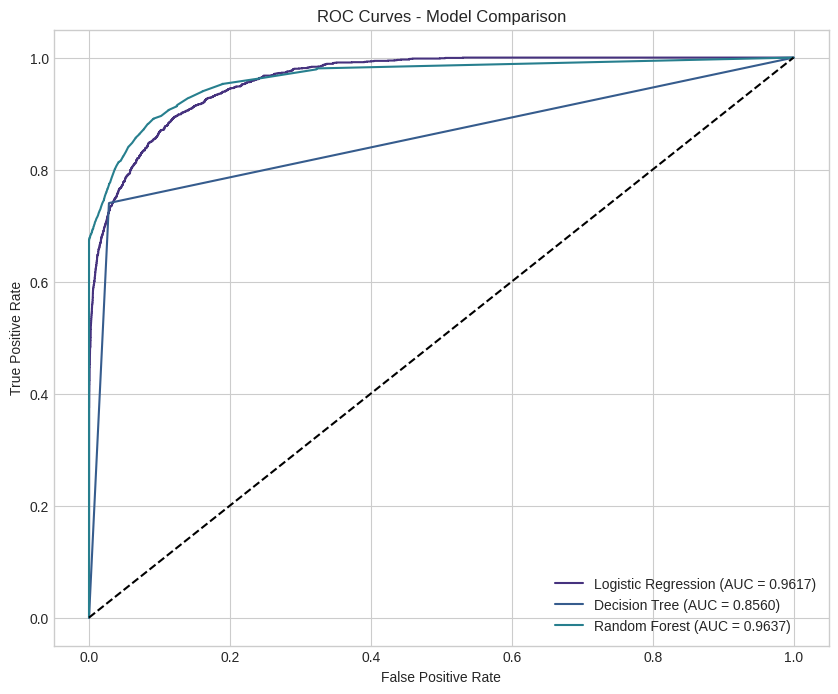

In [39]:
# Compare ROC curves of all models
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/model_comparison_roc.png')
plt.show()

In [40]:
# Compare model performance metrics
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracy = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf)]
precision = [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_rf)]
recall = [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_rf)]
f1 = [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_rf)]
auc = [auc_lr, auc_dt, auc_rf]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUC': auc
})

print("Model Performance Comparison:")
comparison_df

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.95900,0.863934,0.617096,0.719945,0.961690
1,Decision Tree,0.95195,0.709714,0.740047,0.724563,0.855998
2,Random Forest,0.96995,0.946731,0.686768,0.796064,0.963668


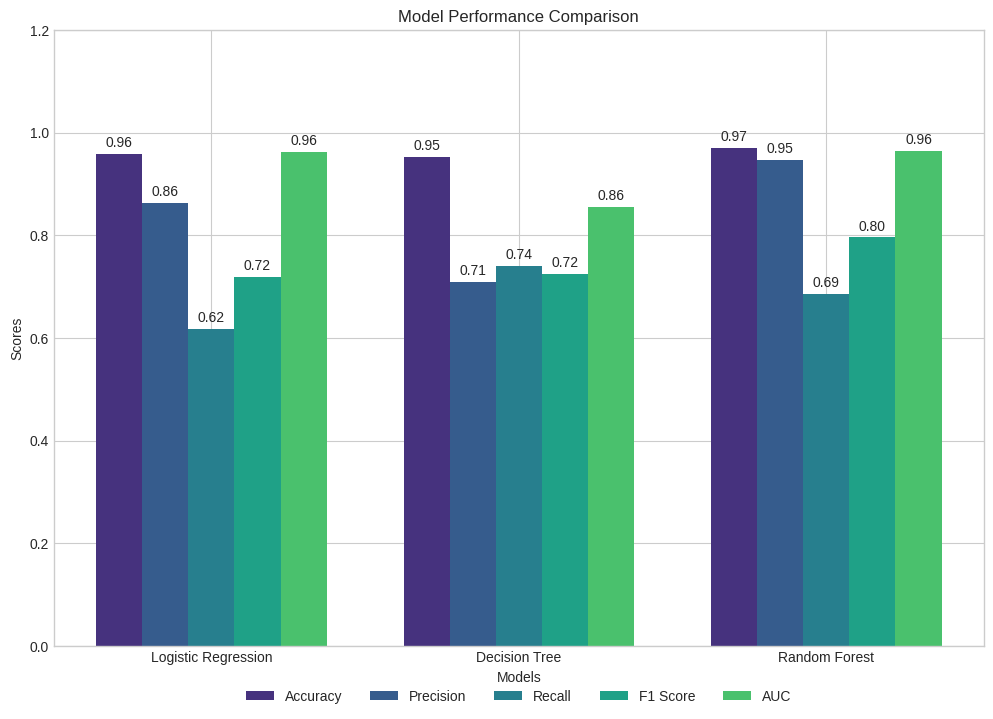

In [41]:
# Visualize model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
comparison_data = comparison_df[metrics].values

plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.15
multiplier = 0

for attribute, measurement in zip(metrics, comparison_data.T):
    offset = width * multiplier
    rects = plt.bar(x + offset, measurement, width, label=attribute)
    plt.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x + width * 2, models)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.ylim(0, 1.2)
plt.savefig('/kaggle/working/model_comparison_metrics.png')
plt.show()

## 8. Feature Importance Analysis

In [42]:
# Get feature importance from Random Forest model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

print("Feature Importance from Random Forest:")
feature_importance

Feature Importance from Random Forest:


,Feature,Importance
0,HbA1c_level,0.397138
1,blood_glucose_level,0.329611
2,bmi,0.121995
3,age,0.100404
4,hypertension,0.014600
5,heart_disease,0.010685
6,gender_Male,0.007010
7,smoking_history_never,0.005169
8,smoking_history_former,0.004357
9,smoking_history_current,0.003233


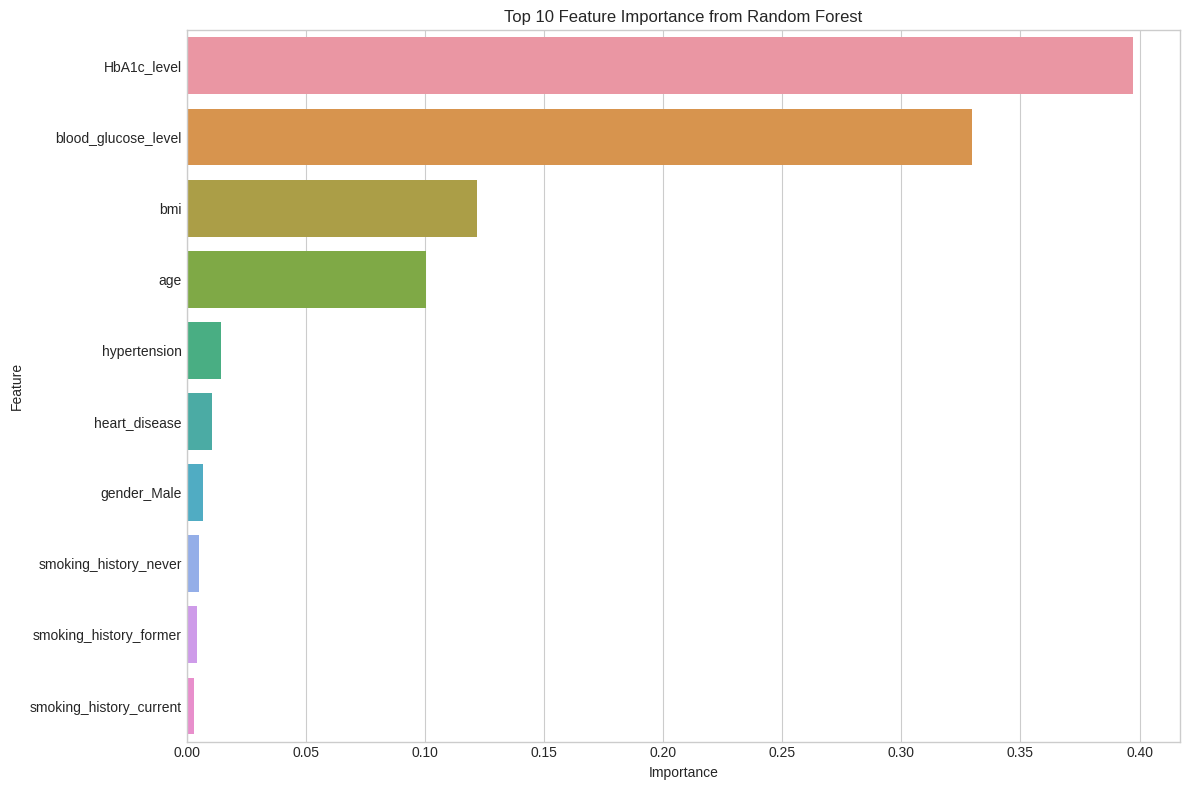

In [43]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('/kaggle/working/feature_importance.png')
plt.show()

## 9. Model Interpretation and Insights

Based on our analysis, we can draw the following insights:

1. **Model Performance**: The Random Forest model performed the best among the three models we built, with the highest accuracy, precision, recall, F1 score, and AUC.

2. **Key Predictors**: The most important features for predicting diabetes are:
   - Blood glucose level
   - HbA1c level
   - Age
   - BMI

3. **Medical Relevance**: This aligns with medical knowledge, as high blood glucose levels and HbA1c levels are directly related to diabetes diagnosis.

4. **Risk Factors**: Age and BMI are significant risk factors for diabetes, which is also consistent with medical literature.

5. **Gender and Lifestyle Factors**: Gender and smoking history have some influence on diabetes risk, but they are less important than the physiological measurements.

## 10. Conclusion and Recommendations

### Conclusion

In this project, we built and compared three machine learning models to predict diabetes based on various health metrics. The Random Forest model performed the best, achieving high accuracy and AUC scores. The most important predictors were blood glucose level, HbA1c level, age, and BMI.

### Recommendations

1. **Regular Monitoring**: Individuals should regularly monitor their blood glucose and HbA1c levels, especially if they are in high-risk categories (older age, high BMI).

2. **Lifestyle Changes**: Maintaining a healthy BMI through diet and exercise can significantly reduce the risk of developing diabetes.

3. **Early Intervention**: Early detection and intervention can help manage diabetes effectively and prevent complications.

4. **Model Deployment**: This model could be integrated into healthcare systems to help identify high-risk individuals who may benefit from preventive interventions.

5. **Further Research**: Future work could explore more complex models or incorporate additional features such as dietary habits, physical activity levels, and family history for even more accurate predictions.

## 11. Save the Best Model

In [44]:
# Import joblib for saving the model
import joblib

# Save the Random Forest model (best performing model)
joblib.dump(rf_model, '/kaggle/working/diabetes_prediction_model.pkl')

# Save the scaler for preprocessing new data
joblib.dump(scaler, '/kaggle/working/scaler.pkl')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
